In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import numpy as np
import pandas as pd
import os
nltk.download('vader_lexicon')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yeetusonthefetus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeetusonthefetus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Path to the folder containing CSV files
folder_path = "data/"

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

In [13]:
combined_df.drop(columns=['author', 'date'], inplace=True)
combined_df = combined_df[combined_df['subreddit'].isin(['addiction', 'adhd', 'alcoholism', 'anxiety', 'autism', 'bpd', 'depression', 'lonely', 'ptsd', 'schizophrenia', 'suicidewatch'])] 

In [14]:
# Tokenize and clean text data (you can use regular expressions for more advanced cleaning)
combined_df['post'] = combined_df['post'].apply(lambda x: x.lower())  # Convert to lowercase

In [15]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yeetusonthefetus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yeetusonthefetus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Tokenization and removing punctuation
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.isalnum()]
    
    # Removing stop words and lemmatization
    stop_words = set(stopwords.words("english"))
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(words)
    
combined_df['cleaned_posts'] = combined_df['post'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeetusonthefetus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the number of features
X_tfidf = tfidf_vectorizer.fit_transform(combined_df['cleaned_posts'])


In [19]:
# You can load pre-trained word embeddings using libraries like gensim
from gensim.models import Word2Vec

# Train Word2Vec model on your preprocessed text data
word2vec_model = Word2Vec(sentences=[text.split() for text in combined_df['cleaned_posts']], vector_size=100, window=5, min_count=1, sg=1)


In [20]:
# Create a function to generate Word2Vec embeddings for a given text
def get_word2vec_features(text, model):
    words = text.split()
    # Initialize an empty vector
    feature_vector = np.zeros((model.vector_size,), dtype="float32")
    num_words = 0
    # Iterate over each word in the text
    for word in words:
        if word in model.wv:
            num_words += 1
            # Add the word's vector to the feature_vector
            feature_vector = np.add(feature_vector, model.wv[word])
    # Divide the result by the number of words to get the average
    if num_words != 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

# Generate Word2Vec features for each post in the DataFrame
combined_df['word2vec_features'] = combined_df['cleaned_posts'].apply(lambda post: get_word2vec_features(post, word2vec_model))


In [21]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_scores(post):
    sentiment = analyzer.polarity_scores(post)
    return sentiment['compound']

combined_df['sentiment'] = combined_df['post'].apply(sentiment_scores)


In [22]:
# Concatenate all features
from scipy.sparse import hstack

X_tfidf_array = X_tfidf.toarray()  # Convert TF-IDF matrix to a dense array
word2vec_arrays = np.array(list(combined_df['word2vec_features']))

In [23]:
print(combined_df[['sentiment']].values.shape)
print(X_tfidf_array.shape)
print(word2vec_arrays.shape)

(374499, 1)
(374499, 1000)
(374499, 100)


In [24]:
sentiment_array = combined_df[['sentiment']].values

# Flatten the sentiment_array
sentiment_array_flat = sentiment_array.flatten()

# Convert sentiment_array_flat to a 2D array
sentiment_array_2d = sentiment_array_flat.reshape(-1, 1)

In [29]:
from gensim import corpora, models


documents = combined_df['cleaned_posts'].str.split()  # Split the preprocessed text into words

# Create a dictionary mapping words to IDs
dictionary = corpora.Dictionary(documents)

# Create a bag of words corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)  # Adjust num_topics as needed

In [33]:
topic_distributions = [lda_model[doc] for doc in corpus]

In [35]:
num_topics = max(len(topic) for topic in topic_distributions)
topic_features = np.zeros((len(topic_distributions), num_topics))  # num_topics is the number of topics in your LDA model

for i, doc_topics in enumerate(topic_distributions):
    for topic, weight in doc_topics:
        topic_features[i, topic] = weight

In [36]:
# shape_tfidf = X_tfidf_array.shape
# shape_word2vec = word2vec_arrays.shape

# # Create an empty array to accommodate the combined data
# X_combined = np.empty((shape_tfidf[0], shape_tfidf[1] + shape_word2vec[1] + 1))

# # Copy data from the original arrays to the combined array
# X_combined[:, :shape_tfidf[1]] = X_tfidf_array
# X_combined[:, shape_tfidf[1]:shape_tfidf[1] + shape_word2vec[1]] = word2vec_arrays
# X_combined[:, -1] = sentiment_array_flat

# Combine the topic modeling output with X_combined
shape_tfidf = X_tfidf_array.shape
shape_word2vec = word2vec_arrays.shape
shape_topic = topic_features.shape  # Shape of the topic modeling output

# Create an empty array to accommodate the combined data
X_combined = np.empty((shape_tfidf[0], shape_tfidf[1] + shape_word2vec[1] + shape_topic[1] + 1))

# Copy data from the original arrays to the combined array
X_combined[:, :shape_tfidf[1]] = X_tfidf_array
X_combined[:, shape_tfidf[1]:shape_tfidf[1] + shape_word2vec[1]] = word2vec_arrays
X_combined[:, shape_tfidf[1] + shape_word2vec[1]:shape_tfidf[1] + shape_word2vec[1] + shape_topic[1]] = topic_features
X_combined[:, -1] = sentiment_array_flat


In [37]:
from sklearn.model_selection import train_test_split

X = combined_df.drop(['subreddit', 'post'],  axis=1)  # Features
y = combined_df['subreddit']  # Target


In [18]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.decomposition import PCA
# # Step 2: Standard Scaling and Min-Max Scaling for numerical features
# standard_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()
# X_final = standard_scaler.fit_transform(X)

# # pca = PCA(n_components=100)  # You can adjust the number of components as needed
# # X_pca = pca.fit_transform(X_final)
# # X_final = minmax_scaler.fit_transform(X)

In [38]:
print(type(X_combined))

<class 'numpy.ndarray'>


In [39]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X_train, X_test, y_train, y_test = train_test_split(X_combined  , y, test_size=0.2, random_state=42)
# from imblearn.under_sampling import RandomUnderSampler

# # Apply random undersampling to the training set
# undersampler = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)



In [40]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)

In [41]:


# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample', verbose=2)

# Fitting the classifier to the training data
rf_classifier.fit(X_train, y_train_encoded)

# Making predictions on the test data
predictions = rf_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test_encoded, predictions)
print("Accuracy:", accuracy)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.7min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.0s


Accuracy: 0.6807743658210947


In [42]:

# Generating a classification report
print("Classification Report:\n", classification_report(y_test_encoded, predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.61      0.72      1577
           1       0.82      0.83      0.83      9182
           2       0.85      0.66      0.74      1254
           3       0.78      0.76      0.77     11419
           4       0.94      0.66      0.77      1754
           5       0.94      0.53      0.68      4899
           6       0.55      0.81      0.65     23472
           7       0.76      0.44      0.55      4724
           8       0.88      0.55      0.67      1766
           9       0.94      0.49      0.64      1788
          10       0.69      0.47      0.56     13065

    accuracy                           0.68     74900
   macro avg       0.82      0.62      0.69     74900
weighted avg       0.72      0.68      0.68     74900



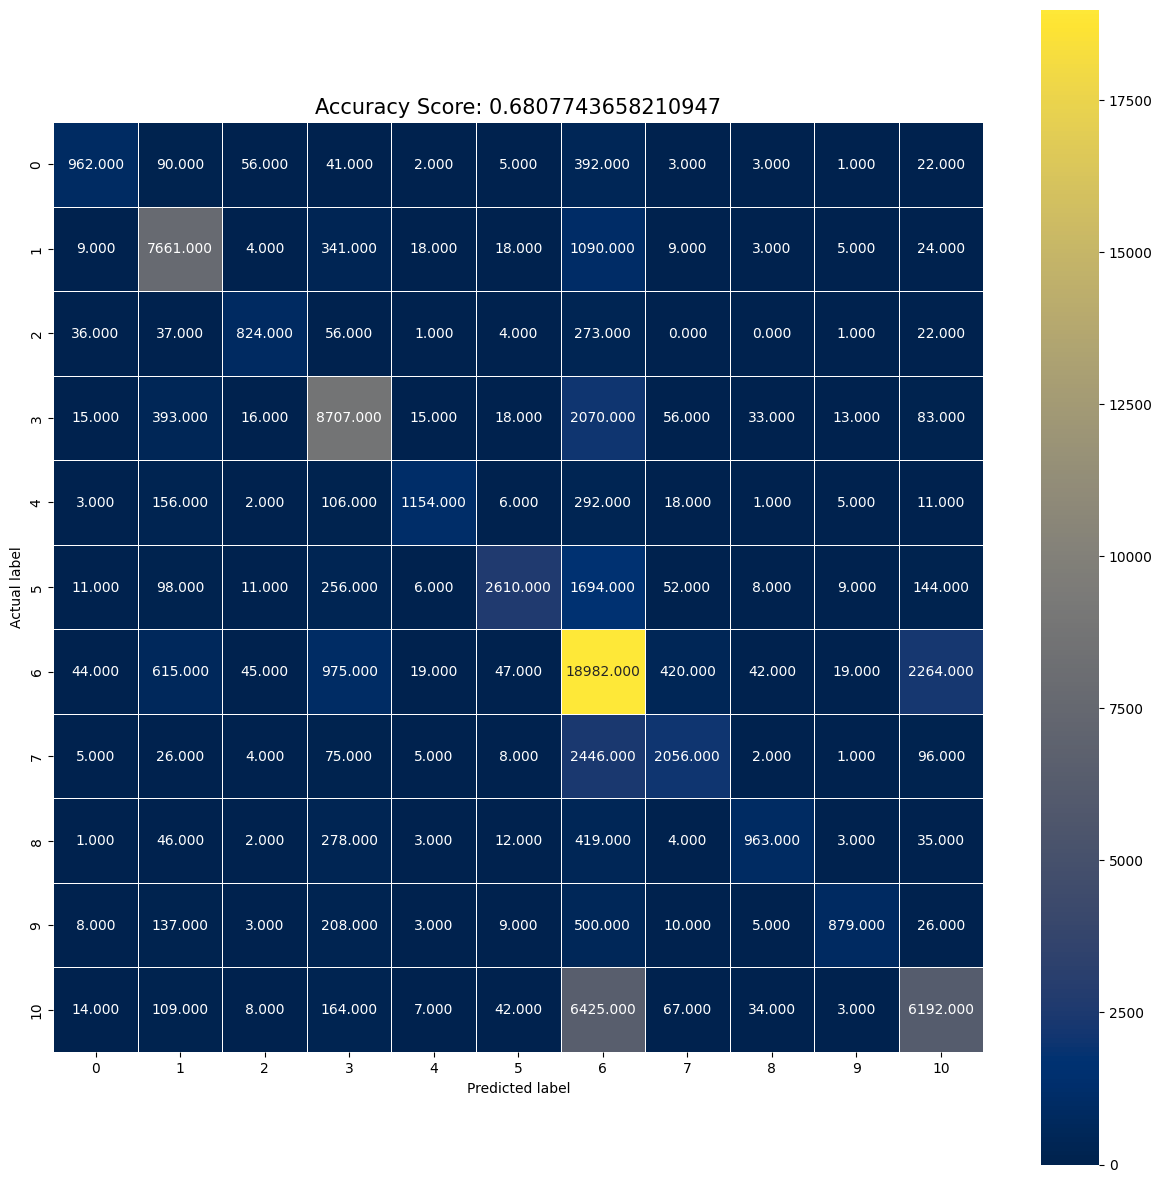

In [43]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='cividis')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(accuracy), size=15)
plt.show()

In [44]:
# Assuming X_combined is your NumPy array
np.save('X_combined.npy', X_combined)

In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have X_combined as your feature matrix and y as your target variable



# Create the XGBoost DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)
# Calculate the class imbalance ratio
positive_class_count = sum(y_train_encoded)
negative_class_count = len(y_train_encoded) - positive_class_count
class_imbalance_ratio = negative_class_count / positive_class_count

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': 11,  # Number of classes
    'eval_metric': 'mlogloss',
    'eta': 0.1,  # Learning rate
    'max_depth': None,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose':2,
    'seed': 42
}

# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# Train XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=pos_weight, class_weight=class_weights)
model.fit(X_train, y_train_encoded)


/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [00:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.DMatrix'>

In [50]:

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 71.15%
